# Project Advanced Line Finding

The goals / steps of this project are the following:

### 1 Camera caiibration
*    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### 2 Create Pipeline
*    Apply a distortion correction to raw images.
*    Use color transforms, gradients, etc., to create a thresholded binary image.
*    Apply a perspective transform to rectify binary image ("birds-eye view").
*    Detect lane pixels and fit to find the lane boundary.
*    Determine the curvature of the lane and vehicle position with respect to center.
*    Warp the detected lane boundaries back onto the original image.

### 3 Video Processing
*    Implement tracking
*    Implement sanity check. Create workflow that chooses fast and slow detect lane alhorythms 
*    Smooth image averaging the previous frames
*    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
 


### Import libraries

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2 
import glob
%matplotlib inline
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# 1 Camera calibration

Computes the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
def camera_calibration(path):    
    # Collect calibration image names
    image_names = glob.glob(path)        
    # Arrays to store 3D object points and 2D image points
    object_points_list = []
    image_points_list = []
    
    # Calcutate object points. Z axis is always 0, because it is a flat object
    # x and y goes from 0 to 8 and from 0 to 5 
    object_points = np.zeros((6 * 9, 3), np.float32)
    object_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # loop through the images
    for image_name in image_names:        
        image = mpimg.imread(image_name)
        
        # images loaded by mpimg.imread are RGB format. convert them to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # find the corners on the image
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        # if corners are found, append object_point_list with the object points 
        # calculated before. Also add the image points (corners)
        if ret == True:
            image_points_list.append(corners)
            object_points_list.append(object_points)
        else:
            print("Calibration failed: " + image_name)
    
    print(str(len(object_points_list)) + " images processed successfuly")
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points_list, image_points_list, gray.shape[::-1], None, None)
    
    return mtx, dist

Calibration failed: camera_cal/calibration5.jpg
Calibration failed: camera_cal/calibration4.jpg
Calibration failed: camera_cal/calibration1.jpg
17 images processed successfuly


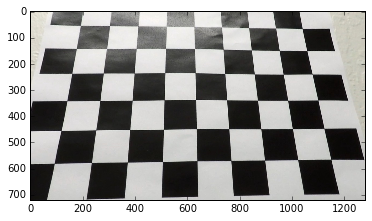

In [3]:
# Test camera calibration

image = mpimg.imread('camera_cal/calibration3.jpg')
plt.imshow(image)  
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')
undist = cv2.undistort(image, mtx, dist)
# Show it

plt.imshow(undist)  


# 2 Create Pipeline

The pipeline creates the lane layer and computes curve radius. Takes the camera calibration results (calibration matrix and distortion parameteres)

In [31]:
# Pipeline
# original variable is the image t hat is kept along the function
# Result is stored in image variable in all stages
def pipeline(original, mtx, dist):
    
    image = undistort_image(original, mtx, dist)
    image = create_warped_binary_image(image)
    image = perspective_transform(image)
    # polyfit_sliding_window()
    # polyfit_near_previous_fit()
    curveture = calculate_curveture()
    # image = merge_images(original, image)
        
    return image, curveture

In [5]:
def undistort_image(image, mtx, dist):
    result = cv2.undistort(image, mtx, dist)
    return result

In [60]:
# Filtering Saturation, hue in HSV color space and filtering x gradient was combined together
# Hue: around 30 is good for selecting yellow line
def create_warped_binary_image(image,sobel_x_thresh=(32,255), sobel_s_thresh=(235,250),sobel_h_thresh=(20,40)):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_channel = hsv[:,:,0]
    s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    
    # Create x oriented gradient on value channel
    sobel_x_v = cv2.Sobel(v_channel, cv2.CV_64F, 1, 0)
    
    # take the absolut values
    sobel_x_v_abs = np.absolute(sobel_x_v)
    result = np.copy(image)
    
    # scale them to 8bit
    sobel_x_v_scaled = np.uint8(255 * sobel_x_v_abs / np.max(sobel_x_v_abs))
    sobel_x_v_binary = np.zeros_like(sobel_x_v_scaled)
    sobel_x_v_binary[(sobel_x_v_scaled >= sobel_x_thresh[0]) & (sobel_x_v_scaled < sobel_x_thresh[1])] = 1
    
    # Create gradient on saturation channel
    sobel_s_binary = np.zeros_like(s_channel)
    sobel_s_binary[(s_channel >= sobel_s_thresh[0]) & (s_channel < sobel_s_thresh[1])] = 1

    # Create gradient on hue channel
    sobel_h_binary = np.zeros_like(h_channel)
    sobel_h_binary[(h_channel >= sobel_h_thresh[0]) & (h_channel < sobel_h_thresh[1])] = 1
    
    # Create stacked image of previous binaries
    stacked = np.dstack((sobel_x_v_binary, sobel_s_binary,sobel_h_binary)) * 255
    return stacked

In [51]:
def perspective_transform(image):
    
    # result = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # source points are got manually with GIMP. Left and right margin are left on the bottom
    # to have some space to left and to right when the car isnt't at the exact center of the
    # lane
    #                          x1b,y1b,   x1t, y1t,   xrt, yrt,   yrb,yrb     
    source =      np.float32([[100,719], [580, 450],[ 710, 455],[1200,719]])    
    # Bottom destination points are equal to the sources. tops are streched out towards x and y
    destination = np.float32([[100,719], [100, 100],[1210, 100],[1200,719]])

    
    # Get the perscpective transform matrix
    M = cv2.getPerspectiveTransform(source, destination)
    print(M)
    cv2.warpPerspective(image, M,(1280,720), image)
    print("transformed")
    return image

In [13]:
def polyfit_sliding_window(image):
    pass

In [14]:
def polyfit_near_previous_fit(image):
    pass

In [9]:
def calculate_curveture():
    curveture = 0
    return curveture

In [16]:
def merge_images(original, lane):
    result = np.copy(original)
    return result  

### Test Pipeline 1 - Create warped binary image

Test starts with the 2nd stage of pipeline. Undistort has been already checked at the previous chapter

Calibration failed: camera_cal/calibration5.jpg
Calibration failed: camera_cal/calibration4.jpg
Calibration failed: camera_cal/calibration1.jpg
17 images processed successfuly
[[ -7.01211284e-01  -1.52799092e+00   1.08521372e+03]
 [  8.03587684e-02  -2.05555570e+00   8.69307237e+02]
 [  1.11764629e-04  -2.56815758e-03   1.00000000e+00]]
transformed
[[ -7.01211284e-01  -1.52799092e+00   1.08521372e+03]
 [  8.03587684e-02  -2.05555570e+00   8.69307237e+02]
 [  1.11764629e-04  -2.56815758e-03   1.00000000e+00]]
transformed
[[ -7.01211284e-01  -1.52799092e+00   1.08521372e+03]
 [  8.03587684e-02  -2.05555570e+00   8.69307237e+02]
 [  1.11764629e-04  -2.56815758e-03   1.00000000e+00]]
transformed
[[ -7.01211284e-01  -1.52799092e+00   1.08521372e+03]
 [  8.03587684e-02  -2.05555570e+00   8.69307237e+02]
 [  1.11764629e-04  -2.56815758e-03   1.00000000e+00]]
transformed
[[ -7.01211284e-01  -1.52799092e+00   1.08521372e+03]
 [  8.03587684e-02  -2.05555570e+00   8.69307237e+02]
 [  1.11764629e-

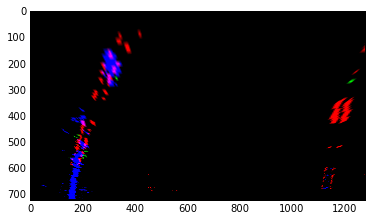

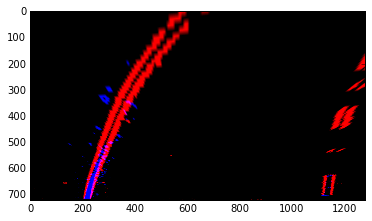

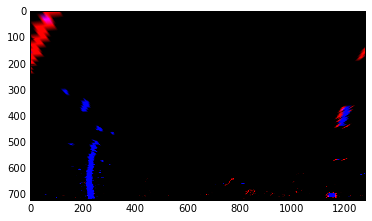

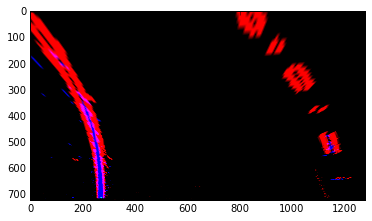

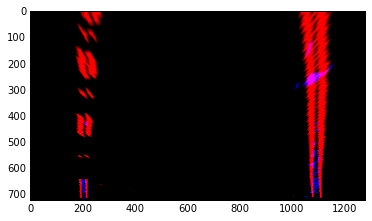

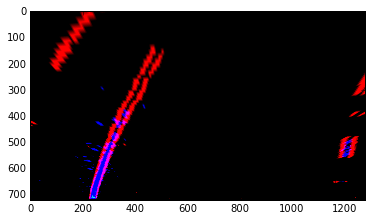

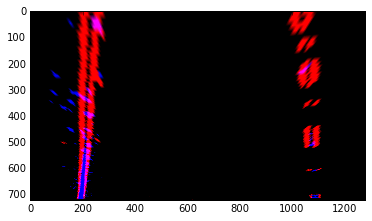

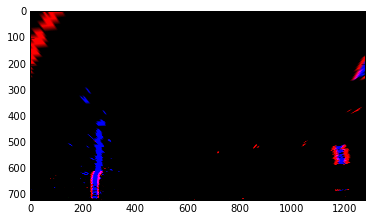

In [61]:
# Test pipeline on image 1

# Run camera calibration
mtx, dist = camera_calibration('camera_cal/calibration*.jpg')

image_names = glob.glob('test_images/*.jpg')                
for image_name in image_names:        
    image = mpimg.imread(image_name)
    # Run pipeline on the image
    result, curveture  = pipeline(image, mtx, dist)
    # create image space
    plt.figure()
    # Show result
    plt.imshow(result)  


### Test Pipeline 2 - Perspective transform

In [ ]:
# Test pipeline on image 2
image = mpimg.imread('test_images/test2.jpg')

# Show it
plt.imshow(image)  

### Test Pipeline 3 - Identify lanes with sliding window, fit with poiynomial 

In [ ]:
# Test pipeline on image 2
image = mpimg.imread('test_images/test2.jpg')

# Show it
plt.imshow(image)  

### Test Pipeline 4 - Identify lanes near precalculated curves, fit with polinomial

In [ ]:
# Test pipeline on image 2
image = mpimg.imread('test_images/test2.jpg')

# Show it
plt.imshow(image)  

### Test Pipeline 5 - Calculate radius of curvature

In [ ]:
# Test pipeline on image 2
image = mpimg.imread('test_images/test2.jpg')

# Show it
plt.imshow(image)  

### Test Pipeline 6 - Put lane on the original image

In [ ]:
# Test pipeline on image 2
image = mpimg.imread('test_images/test2.jpg')

# Show it
plt.imshow(image)  

# 3 Video processing

### Tracking 

### Sanity Check

### Smoothing

### Drawing

### Generate video output

In [ ]:
# ??? Redundant with Drawing 
def process_image(image):    
    return pipeline(image)


In [ ]:
output_video = 'output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)
